In [2]:
# ==========================================
# CHUNK 0: MASTER SETUP & IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

SAMPLE_SIZE = 100000  

df_flights = pd.read_csv('US_flights_2023.csv', low_memory=False)
df_airports = pd.read_csv('airports_geolocation.csv')
df_weather = pd.read_csv('weather_meteo_by_airport.csv')

df_flights['FlightDate'] = pd.to_datetime(df_flights['FlightDate'])
df_weather['time'] = pd.to_datetime(df_weather['time'])

if SAMPLE_SIZE and len(df_flights) > SAMPLE_SIZE:
    print(f"   -> Sampling {SAMPLE_SIZE} rows...")
    df_flights = df_flights.sample(n=SAMPLE_SIZE, random_state=42)

# MERGE AIRPORTS
df_merged = df_flights.merge(
    df_airports[['IATA_CODE', 'STATE']], 
    left_on='Dep_Airport', 
    right_on='IATA_CODE', 
    how='left'
)
df_merged = df_merged.rename(columns={'STATE': 'Origin_State'}).drop(columns=['IATA_CODE'])

# MERGE WEATHER
df_final = df_merged.merge(
    df_weather[['airport_id', 'time', 'prcp', 'snow', 'wspd', 'tavg']],
    left_on=['Dep_Airport', 'FlightDate'],
    right_on=['airport_id', 'time'],
    how='left'
)
df_final = df_final.drop(columns=['airport_id', 'time'])

print(f"SETUP COMPLETE. 'df_final' is ready. Shape: {df_final.shape}")

   -> Sampling 100000 rows...
SETUP COMPLETE. 'df_final' is ready. Shape: (100000, 29)


In [3]:
# ==========================================
# CHUNK 1: Feature Selection & Split
# ==========================================
print("--- Setting up Final Regression Data ---")

# 1. FINAL FEATURES
features_final = [
    'Dep_Delay',          
    'Flight_Duration',    
    'Day_Of_Week', 
    'DepTime_label',      
    'Airline',
    'Aicraft_age',
    'Origin_State',
    'tavg', 'prcp', 'wspd' 
]
target = 'Arr_Delay'

# 2. FILTER & CLEAN
df_reg = df_final[features_final + [target]].copy()
df_reg = df_reg.dropna()

# 3. SAMPLING FOR MODELING
SAMPLE_N = SAMPLE_SIZE 
if SAMPLE_N and len(df_reg) > SAMPLE_N:
    df_reg = df_reg.sample(SAMPLE_N, random_state=42)

# 4. SPLIT
X = df_reg.drop(columns=[target])
y = df_reg[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Ready. Training on {len(X_train)} rows, Testing on {len(X_test)} rows.")

--- Setting up Final Regression Data ---
Data Ready. Training on 80000 rows, Testing on 20000 rows.


--- Phase I: Data Cleaning & EDA Audit ---


Duplicates Removed: 0
Missing Values Status: 0 (Cleaned via DropNA)


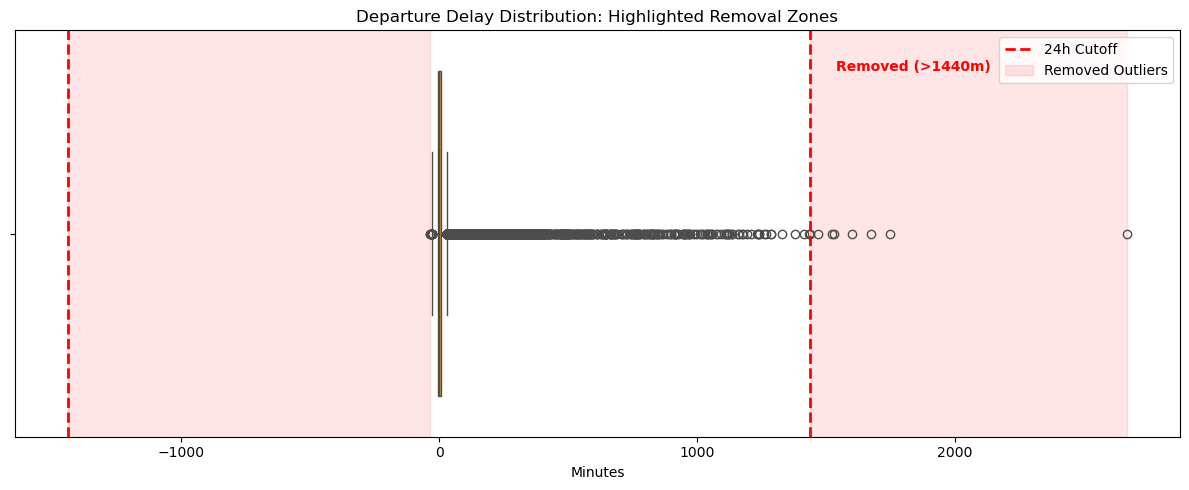

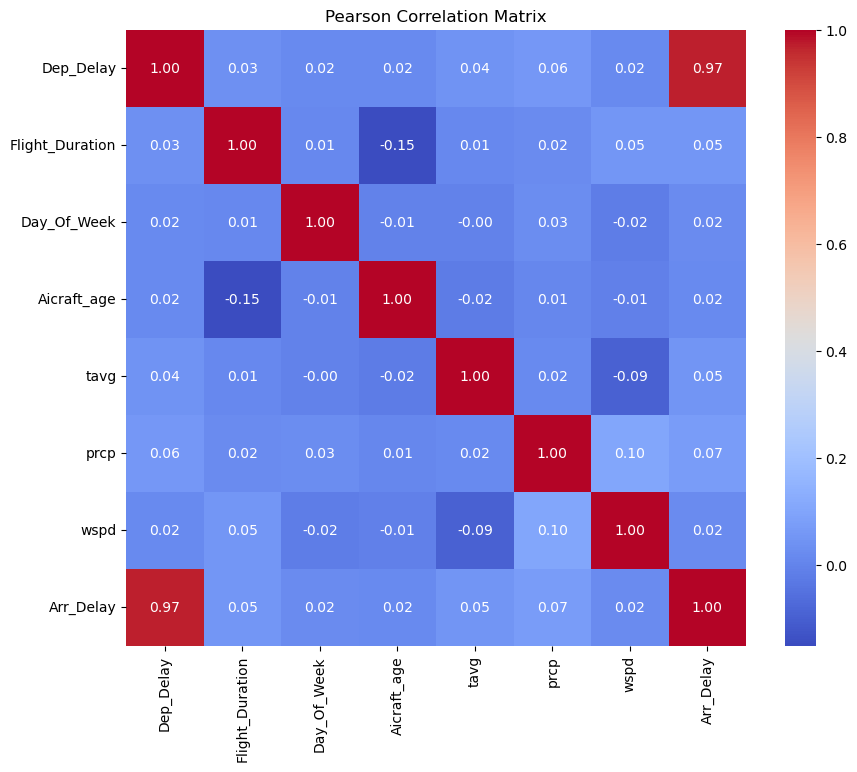


--- VIF Analysis ---
           feature        VIF
7        intercept  21.606805
1  Flight_Duration   1.028347
3      Aicraft_age   1.024615
6             wspd   1.023152
5             prcp   1.015507
4             tavg   1.012458
0        Dep_Delay   1.007478
2      Day_Of_Week   1.001878

--- Sample Covariance Matrix ---


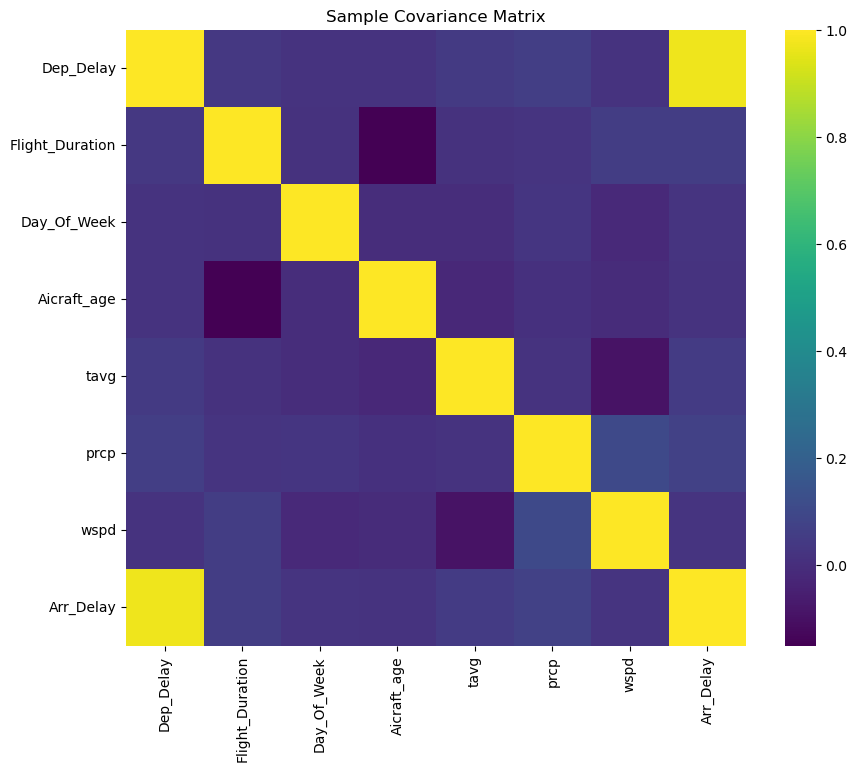

In [ ]:

from sklearn.discriminant_analysis import StandardScaler


print("--- Phase I: Data Cleaning & EDA Audit ---")

initial_len = len(df_reg)
df_reg = df_reg.drop_duplicates()
print(f"Duplicates Removed: {initial_len - len(df_reg)}")

print(f"Missing Values Status: {df_reg.isna().sum().sum()} (Cleaned via DropNA)")

plt.figure(figsize=(12, 5))

sns.boxplot(x=df_reg['Dep_Delay'], color='orange')

cutoff_upper = 1440
cutoff_lower = -1440

plt.axvline(x=cutoff_upper, color='red', linestyle='--', linewidth=2, label='24h Cutoff')
plt.axvline(x=cutoff_lower, color='red', linestyle='--', linewidth=2)

plt.axvspan(xmin=cutoff_upper, xmax=df_reg['Dep_Delay'].max(), color='red', alpha=0.1, label='Removed Outliers')
plt.axvspan(xmin=df_reg['Dep_Delay'].min(), xmax=cutoff_lower, color='red', alpha=0.1)

plt.text(x=cutoff_upper + 100, y=-0.4, s='Removed (>1440m)', color='red', fontweight='bold')

plt.title('Departure Delay Distribution: Highlighted Removal Zones')
plt.xlabel('Minutes')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

impossible_flights = df_reg[df_reg['Flight_Duration'] <= 0]
if len(impossible_flights) > 0:
    df_reg = df_reg[df_reg['Flight_Duration'] > 0]
    print(f" -> Removed {len(impossible_flights)} impossible flights (Duration <= 0).")


plt.figure(figsize=(10, 8))
numeric_df = df_reg.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()

print("\n--- VIF Analysis ---")
X_vif = numeric_df.drop(columns=['Arr_Delay'], errors='ignore')
X_vif['intercept'] = 1 

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(vif_data.sort_values('VIF', ascending=False))


# apply standard scaling


scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_df)
print("\n--- Sample Covariance Matrix ---")
plt.figure(figsize=(10, 8))

sns.heatmap(pd.DataFrame(numeric_scaled, columns=numeric_df.columns).cov(), annot=False, cmap='viridis') 

plt.title('Sample Covariance Matrix')
plt.show()



In [ ]:
 
def outlier_audit(df, features):
    num_feats = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
    cat_feats = [c for c in features if c not in num_feats]
    
    report_rows = []
    for c in num_feats:
        col = df[c]
        q1, q3 = col.quantile(0.25), col.quantile(0.75)
        iqr = q3 - q1
        lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        z = (col - col.mean()) / (col.std(ddof=0) if col.std(ddof=0) != 0 else 1)
        
        report_rows.append({
            "feature": c, "dtype": str(col.dtype), "count": len(col),
            "min": float(col.min()), "mean": float(col.mean()), "max": float(col.max()),
            "outliers_1.5IQR": int(((col < lb) | (col > ub)).sum()),
            "outliers_z>4": int((z.abs() > 4).sum())
        })
        
    display(pd.DataFrame(report_rows).set_index('feature'))
    
    flags = pd.Series(False, index=df.index)
    if 'Flight_Duration' in df.columns: flags |= (df['Flight_Duration'] <= 0)
    if 'Aicraft_age' in df.columns: flags |= (df['Aicraft_age'] > 80)
    if 'prcp' in df.columns: flags |= (df['prcp'] > 500)
    if 'wspd' in df.columns: flags |= (df['wspd'] > 200)
    if 'tavg' in df.columns: flags |= (df['tavg'] < -80) | (df['tavg'] > 60)
    
    return {"flag_index": df.index[flags]}

audit = outlier_audit(X, features_final)

X_clean = X.drop(index=audit['flag_index'])
y_clean = y.drop(index=audit['flag_index'])
print(f"Audit Complete. Rows removed: {len(audit['flag_index'])}")

,dtype,count,min,mean,max,outliers_1.5IQR,outliers_z>4
feature,,,,,,,
Dep_Delay,int64,100000,-35.0,12.087880,2668.0,12621,771
Flight_Duration,int64,100000,16.0,140.092610,691.0,5081,169
Day_Of_Week,int64,100000,1.0,3.989370,7.0,0,0
Aicraft_age,int64,100000,1.0,13.460970,57.0,50,50
tavg,float64,100000,-32.2,16.775486,42.2,322,21
prcp,float64,100000,0.0,2.450919,571.5,21301,1216
wspd,float64,100000,0.0,12.472307,51.3,2146,162


Audit Complete. Rows removed: 1


In [17]:
# ==========================================
# CHUNK 2: The Pipeline Setup
# ==========================================
# Identify columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

print("Pipeline defined.")
print(f"Numeric: {num_cols}")
print(f"Categorical: {cat_cols}")

# Quick Check on Delay Balance
delay_threshold = 15
print(f"Train Delayed > 15min: {(y_train > delay_threshold).sum()}")
print(f"Test Delayed > 15min:  {(y_test > delay_threshold).sum()}")

Pipeline defined.
Numeric: ['Dep_Delay', 'Flight_Duration', 'Day_Of_Week', 'Aicraft_age', 'tavg', 'prcp', 'wspd']
Categorical: ['DepTime_label', 'Airline', 'Origin_State']
Train Delayed > 15min: 15785
Test Delayed > 15min:  3926


In [ ]:
# ==========================================
# CHUNK 3: Model Training & Evaluation
# ==========================================
def train_and_score(name, model):
    print(f"\nTraining {name}...")
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"  -> RMSE: {rmse:.4f} min")
    print(f"  -> R2:   {r2:.4f}")
    return {'RMSE': rmse, 'R2': r2, 'Model': pipe}

# Train Baseline
results = {}
results['Linear'] = train_and_score("Linear Regression", LinearRegression())


Training Linear Regression...
  -> RMSE: 13.7045 min
  -> R2:   0.9444


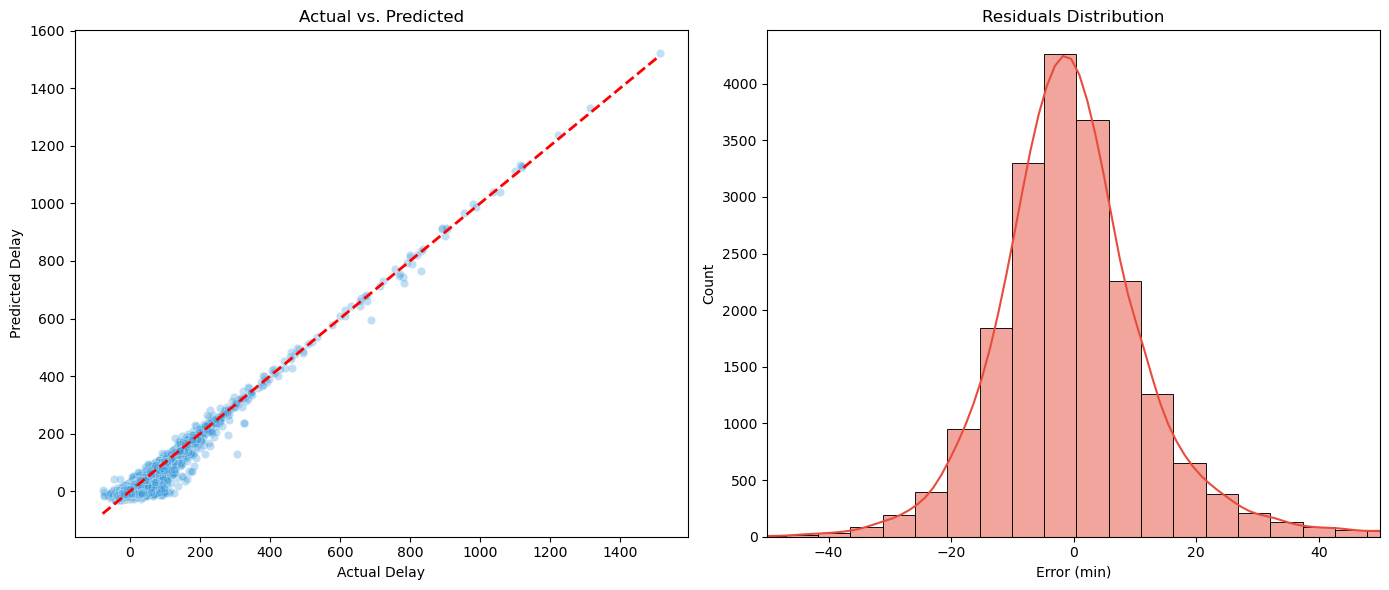

Model R2: 0.9444


In [8]:
# ==========================================
# CHUNK 4: Diagnostics (Visuals)
# ==========================================
final_model_pipe = results['Linear']['Model']
final_model_obj = final_model_pipe.named_steps['model']

y_pred_final = final_model_pipe.predict(X_test)
residuals = y_test - y_pred_final

plt.figure(figsize=(14, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.3, color='#3498db')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Delay'); plt.ylabel('Predicted Delay')

# Plot 2: Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='#e74c3c', bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Error (min)'); plt.xlim(-50, 50)

plt.tight_layout()
plt.show()

print(f"Model R2: {r2_score(y_test, y_pred_final):.4f}")

--- Phase II: Statistical Analysis (Syllabus Requirements) ---
Running Stepwise Regression on 78 features...
                            OLS Regression Results                            
Dep. Variable:              Arr_Delay   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 3.179e+04
Date:                Sat, 06 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:13:08   Log-Likelihood:            -4.0217e+05
No. Observations:              100000   AIC:                         8.044e+05
Df Residuals:                   99946   BIC:                         8.050e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.9

,Metric,Value
0,Adjusted R-Squared,0.943970
1,AIC,804438.706252
2,BIC,804952.404227
3,MSE,182.357700


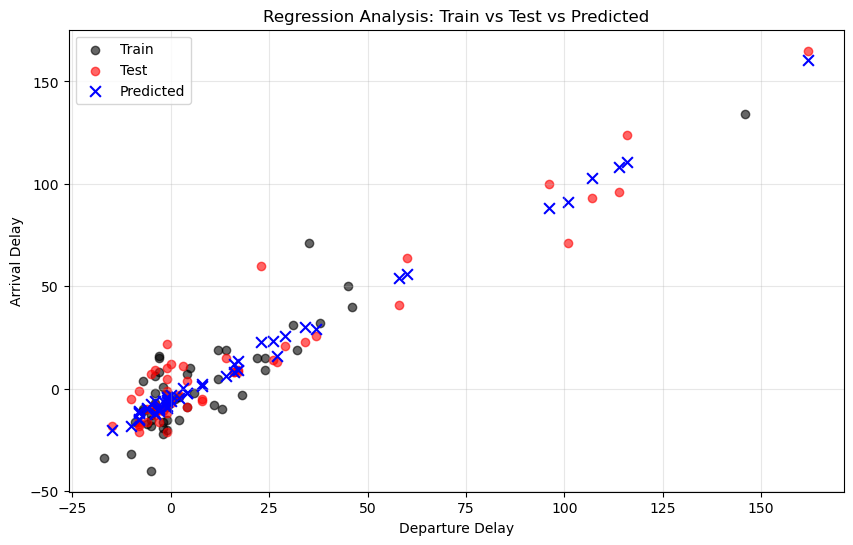

In [ ]:
# ==========================================
# CHUNK 5: Phase II - Statistical Inference & Stepwise Regression
# ==========================================
print("--- Phase II: Statistical Analysis ---")

# 1. PREP DATA
STATS_SAMPLE = 100000 
df_stats = df_reg.sample(n=min(len(df_reg), STATS_SAMPLE), random_state=42).copy()
df_stats_encoded = pd.get_dummies(df_stats, columns=cat_cols, drop_first=True, dtype=int)

y_sm = df_stats_encoded['Arr_Delay'].astype(float)
X_sm = df_stats_encoded.drop(columns=['Arr_Delay']).astype(float)
X_sm = sm.add_constant(X_sm)

# 2. STEPWISE REGRESSION
def backward_elimination(X, y, sl=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        X_curr = X[features]
        if X_curr.empty: break
        model = sm.OLS(y, X_curr).fit()
        p_values = model.pvalues
        max_p = p_values.max()
        if max_p > sl:
            worst = p_values.idxmax()
            if worst == 'const' and len(features) > 1:
                # Try to find next worst if const is worst
                worst = p_values.drop('const').idxmax()
                if p_values[worst] <= sl: break
            features.remove(worst)
        else:
            break
    return model, features

print(f"Running Stepwise Regression on {len(X_sm.columns)} features...")
final_sm_model, selected_features = backward_elimination(X_sm, y_sm)

print(final_sm_model.summary())

metrics_df = pd.DataFrame({
    "Metric": ["Adjusted R-Squared", "AIC", "BIC", "MSE"],
    "Value": [final_sm_model.rsquared_adj, final_sm_model.aic, final_sm_model.bic, final_sm_model.mse_resid]
})
display(metrics_df)

plt.figure(figsize=(10, 6))
plot_n = 50
viz_df = df_stats.sample(n=plot_n*2, random_state=99).copy()
viz_encoded = pd.get_dummies(viz_df, columns=cat_cols, drop_first=True, dtype=int)
viz_encoded = sm.add_constant(viz_encoded).astype(float)
viz_encoded = viz_encoded.reindex(columns=selected_features, fill_value=0)

viz_train = viz_encoded.iloc[:plot_n]
viz_test = viz_encoded.iloc[plot_n:]
viz_y_train = y_sm.loc[viz_train.index]
viz_y_test = y_sm.loc[viz_test.index]
viz_pred = final_sm_model.predict(viz_test)

plt.scatter(viz_train['Dep_Delay'], viz_y_train, color='black', alpha=0.6, label='Train')
plt.scatter(viz_test['Dep_Delay'], viz_y_test, color='red', alpha=0.6, label='Test')
plt.scatter(viz_test['Dep_Delay'], viz_pred, color='blue', marker='x', s=60, label='Predicted')
plt.title('Regression Analysis: Train vs Test vs Predicted')
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()